In [1]:
# stdlib
from typing import Any, List

# third party
import numpy as np
import pandas as pd
#from ctgan import CTGAN

# synthcity absolute
from synthcity.plugins.core.dataloader import DataLoader, GenericDataLoader
from synthcity.plugins.core.distribution import Distribution
from synthcity.plugins.core.plugin import Plugin
from synthcity.plugins.core.schema import Schema
from synthcity.plugins.core.distribution import (
    Distribution,
    IntegerDistribution,
)
from tabpfn import TabPFNClassifier
import torch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
#from ForestDiffusion import ForestDiffusionModel
from synthcity.plugins import Plugins
from smote import MySMOTE
from imblearn.over_sampling import SMOTE

In [2]:
/data/parietal/store/work/lgrinszt/differentiate_tabpfn/improve_tabpfn.ipynb

NameError: name 'data' is not defined

In [ ]:
class tabpfn_points_plugin(Plugin):
    """TabPFN integration in synthcity."""

    def __init__(
        self,
        n_random_test_samples: int = 3_000,
        device: str = "cuda:0",
        n_batches: int = 200,
        lr: float = 0.1,
        n_permutations: int = 3,
        n_ensembles: int = 3,
        store_intermediate_data: bool = False,
        **kwargs: Any
    ) -> None:
        super().__init__(**kwargs)
        self.n_random_test_samples = n_random_test_samples
        self.device = device
        self.n_batches = n_batches
        self.lr = lr
        self.n_permutations = n_permutations
        self.n_ensembles = n_ensembles
        self.preprocessor = StandardScaler()
        self.store_intermediate_data = store_intermediate_data
        if store_intermediate_data:
            self.loss_list = []
            self.all_X_false_train = []


    @staticmethod
    def name() -> str:
        return "tabpfn_points"

    @staticmethod
    def type() -> str:
        return "debug"

    @staticmethod
    def hyperparameter_space(**kwargs: Any) -> List[Distribution]:
        """
        We can customize the hyperparameter space, and use it in AutoML benchmarks.
        """
        #TODO
        return [
            IntegerDistribution(name="embedding_n_units", low=100, high=500, step=50),
            IntegerDistribution(name="batch_size", low=100, high=300, step=50),
            IntegerDistribution(name="n_iter", low=100, high=500, step=50),
        ]

    def _fit(self, X: DataLoader, X_false_train_init=None, *args: Any, **kwargs: Any) -> "tabpfn_points_plugin":
        if X_false_train_init is None:
            X_false_train = (np.random.rand(512, X.shape[1]) * 4 - 2) / 5.
        else:
            X_false_train = X_false_train_init
        self.X_false_train = torch.tensor(X_false_train).float().to(self.device)
        self.X_false_train.requires_grad = True
        X_true = self.preprocessor.fit_transform(X.numpy()) # all numerical features for now
        X_true = torch.tensor(X_true, dtype=torch.float32).to(self.device)
        X_random_test = np.random.rand(self.n_random_test_samples, X.shape[1]) * 4 - 2
        X_random_test = torch.tensor(X_random_test).float().to(self.device)

        n_test_from_false_train = 512

        optimizer = torch.optim.Adam([self.X_false_train], lr=self.lr)

        tabpfn_classifier = TabPFNClassifier(device=self.device, N_ensemble_configurations=self.n_permutations,
                                              no_preprocess_mode=True, no_grad=False, normalize=False)

        for batch in tqdm(range(self.n_batches)):
            n_train = 512
            n_test = min(2048, X_true.shape[0])
            tabpfn_output_proba_list = []
            for _ in range(self.n_ensembles):
                indices_train = np.random.choice(X_true.shape[0], n_train, replace=False)
                X_batch_train = X_true[indices_train]
                indices_test = np.random.choice(X_true.shape[0], n_test, replace=False)
                X_batch_test = X_true[indices_test]
                #indices_false_test = np.random.choice(X_random_test.shape[0], len(X_batch_test), replace=False)
                #X_false_test = X_random_test[indices_false_test]
                indices_false_test_from_random = np.random.choice(X_random_test.shape[0], len(X_batch_test) - n_test_from_false_train, replace=False)
                X_false_test_from_random = X_random_test[indices_false_test_from_random]
                indices_false_test_from_false_train = np.random.choice(self.X_false_train.shape[0], n_test_from_false_train, replace=False)
                X_false_test_from_false_train = self.X_false_train.detach()[indices_false_test_from_false_train]
                X_false_test = torch.cat((X_false_test_from_random, X_false_test_from_false_train), dim=0)

                indices_false_train = np.random.choice(self.X_false_train.shape[0], len(X_batch_train), replace=False)
                X_false_batch_train = self.X_false_train[indices_false_train]

                X_train = torch.cat((X_batch_train, X_false_batch_train), dim=0)
                X_test = torch.cat((X_batch_test, X_false_test), dim=0)
                y_train = torch.cat((torch.ones(X_batch_train.shape[0]), torch.zeros(X_false_batch_train.shape[0])), dim=0).long()
                y_test = torch.cat((torch.ones(X_batch_test.shape[0]), torch.zeros(X_false_test.shape[0])), dim=0).long()
                #y_test = torch.ones(X_batch_test.shape[0]).long()
                #y_test = torch.zeros(X_false_test.shape[0]).long()

                perm_train = torch.randperm(X_train.shape[0])
                X_train = X_train[perm_train]
                y_train = y_train[perm_train]
                perm_test = torch.randperm(X_test.shape[0])
                X_test = X_test[perm_test]
                y_test = y_test[perm_test]

                # add a third feature to X_train and X_test with random values
                X_train = torch.cat((X_train, torch.randn(X_train.shape[0], 1).to(self.device)), dim=1)
                X_test = torch.cat((X_test, torch.randn(X_test.shape[0], 1).to(self.device)), dim=1)
                tabpfn_classifier.fit(X_train, y_train, overwrite_warning=True)
                tabpfn_output_proba = tabpfn_classifier.predict_proba(X_test)
                tabpfn_output_proba_list.append(tabpfn_output_proba)
            tabpfn_output_proba = torch.stack(tabpfn_output_proba_list).mean(dim=0)

            loss = torch.mean(torch.abs((tabpfn_output_proba[:, 0] - tabpfn_output_proba[:, 1]))**2)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            if self.store_intermediate_data:
                self.loss_list.append(loss.item())
                self.all_X_false_train.append(self.X_false_train.detach().cpu().numpy())
    
        return tabpfn_output_proba.detach().cpu(), self.X_false_train.detach().cpu(), y_test.detach().cpu()

    def sample(self, count: int, **kwargs: Any) -> pd.DataFrame:
        if count > len(self.X_false_train):
            raise ValueError("Requested count exceeds the available data.")
        indices = np.random.choice(len(self.X_false_train), count, replace=False)
        false_points = self.X_false_train[indices].detach().cpu().numpy()
        return self.preprocessor.inverse_transform(false_points)
    
    def _generate(self, count: int, syn_schema: Schema, **kwargs: Any) -> pd.DataFrame:
        return self._safe_generate(self.sample, count, syn_schema)
    

[2024-10-15T12:23:35.459179+0200][2279777][CRITICAL] module disabled: /data/parietal/store/work/lgrinszt/synthcity/src/synthcity/plugins/generic/plugin_goggle.py
INFO:datasets:PyTorch version 2.3.1+cu118 available.
INFO:openml.datasets.dataset:pickle load data houses
[2024-10-15T12:23:37.920163+0200][2279777][CRITICAL] module disabled: /data/parietal/store/work/lgrinszt/synthcity/src/synthcity/plugins/generic/plugin_goggle.py


encoders None


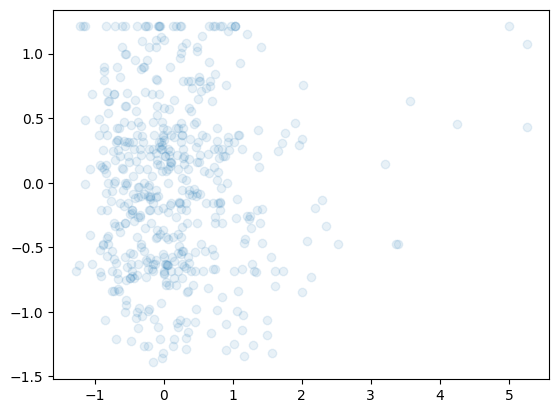

In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import GenericDataLoader
from sklearn.preprocessing import RobustScaler
from synthcity_addons import generators
import numpy as np
#X, _ = make_moons(n_samples=5000, noise=0.1)
import openml

task_id = 361078
task = openml.tasks.get_task(task_id)
X, y = task.get_X_and_y()
# shuffle
indices = np.random.permutation(X.shape[0])
X = X[indices]
y = y[indices]

#normalize
X = RobustScaler().fit_transform(X)

X = X[:, :4]

loader = GenericDataLoader(X)


device = "cuda:0"

# syn_model = Plugins().get("tabpfn_points", n_batches=100, lr=0.02, store_intermediate_data=True, initialization_strategy="smote",
#                            store_animation_path="animation.mp4", device=device, use_kmeans_tabpfn=True, n_clusters_kmeans_tabpfn=5, n_ensembles=1,
#                           loss="adjusted", noise_std=1)
#syn_model = Plugins().get("ddpm")
#syn_model = tabpfn_points_plugin(n_batches=2, lr=0.1, store_intermediate_data=True, initialization_strategy="smote", store_animation_path="animation.mp4")
#tabpfn_output_proba, X_false_train, y_test = syn_model.fit(loader)
syn_model = Plugins().get("smote")
syn_model.fit(loader)

false_data = syn_model.generate(512).numpy()
plt.scatter(false_data[:, 0], false_data[:, 1], alpha=0.1)
#plt.title(method)


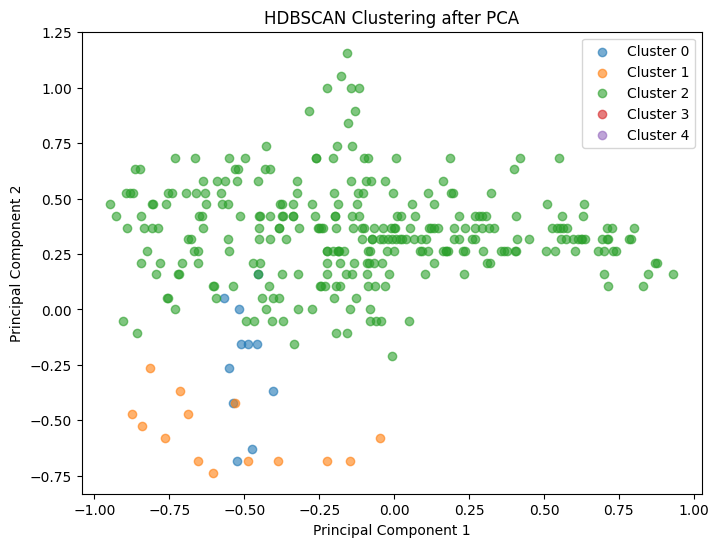

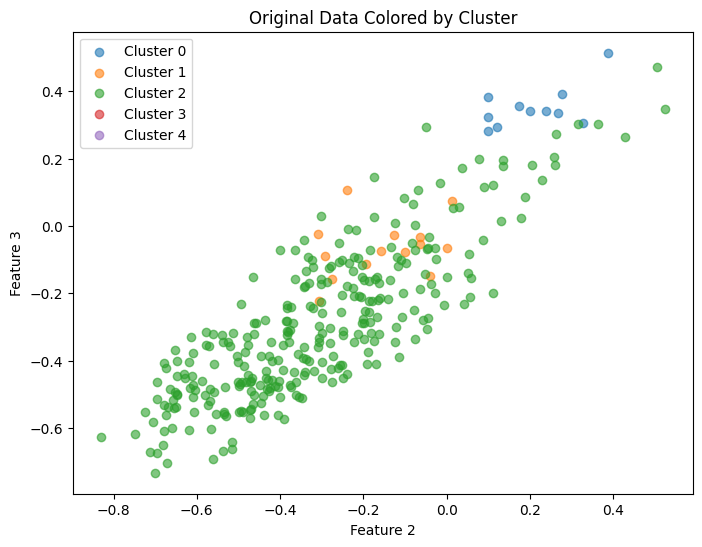

In [4]:
i, j = 2, 3

from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, HDBSCAN
from sklearn.decomposition import PCA

# Number of clusters
n_clusters = 5

X_small = X[:2048]

# Perform PCA for dimension reduction
#pca = PCA(n_components=2)
#X_small_reduced = pca.fit_transform(X_small)
X_small_reduced = X_small

# Perform HDBSCAN clustering
kmeans = HDBSCAN(min_cluster_size=10)
clusters = kmeans.fit_predict(X_small_reduced)

# Plot the clusters
plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    plt.scatter(X_small_reduced[clusters == cluster, 0], X_small_reduced[clusters == cluster, 1], label=f'Cluster {cluster}', alpha=0.6)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('HDBSCAN Clustering after PCA')
plt.show()

# Plot the original data colored by cluster
plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    plt.scatter(X_small[clusters == cluster, i], X_small[clusters == cluster, j], label=f'Cluster {cluster}', alpha=0.6)

plt.xlabel(f'Feature {i}')
plt.ylabel(f'Feature {j}')
plt.legend()
plt.title('Original Data Colored by Cluster')
plt.show()



Accuracy of GradientBoostingClassifier: 0.5866
NORMALIZING
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Accuracy of TabPFNClassifier: 0.4732
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
Shape of X_train_cluster: torch.Size([143, 4])
Number of each classes (array([0., 1.]), array([70, 73]))
NORMALIZING
Shape of X_train_cluster: torch.Size([3100, 4])
Number of each classes (array([0., 1.]), array([1568, 1532]))
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Shape of X_train_cluster: torch.Size([19, 4])
Number of each classes (array([0., 1.]), array([ 9, 10]))
NORMALIZING
Shape of X_train_cluster: torch.Size([6, 4])
Number of each classes (array([0., 1.]), array([4, 2]))
Shape of X_train_cluster: torch.Size([5, 4])
Number of each classes (array([0., 1.]), array([4, 1]))
NORMALIZING
Accuracy of KmeanTabPFNClassifier: 0.4841
Accuracy of DummyClassifier: 0.4756


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Accuracy of GradientBoostingClassifier on i, j: 0.6598
NORMALIZING
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Accuracy of TabPFNClassifier on i, j: 0.5134
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
Shape of X_train_cluster: torch.Size([4, 2])
Number of each classes (array([0., 1.]), array([2, 2]))
Shape of X_train_cluster: torch.Size([3255, 2])
Number of each classes (array([0., 1.]), array([1649, 1606]))
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Shape of X_train_cluster: torch.Size([11, 2])
Number of each classes (array([0., 1.]), array([4, 7]))
NORMALIZING
Accuracy of KmeanTabPFNClassifier on i, j: 0.5061
Accuracy of DummyClassifier on i, j: 0.4756


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


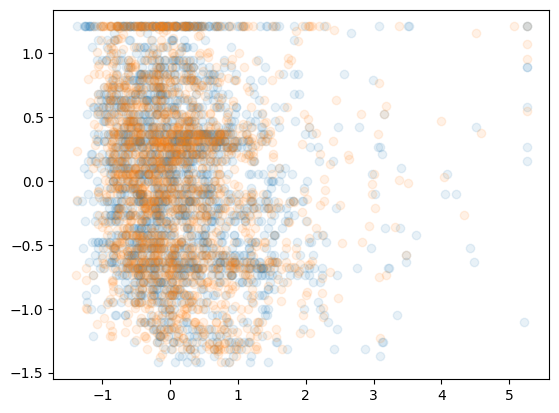

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from tabpfn import TabPFNClassifier
from kmean_tabpfn import KmeanTabPFNClassifier, HDBSCANTabPFNClassifier
import torch

size_to_generate = 2048
size_true = 2048

X_false = syn_model.generate(size_to_generate).numpy()
#X_false = syn_model.all_X_false_train[-1]#.cpu().numpy()
#X_true = syn_model.X_true[-size_true:, ].cpu().numpy()
X_true = X[-size_true:, :]

i, j = 0, 1
# plot
plt.scatter(X_true[:, i], X_true[:, j], alpha=0.1)
plt.scatter(X_false[:, i], X_false[:, j], alpha=0.1)

X_combined = np.vstack((X_true, X_false))
y_combined = np.hstack((np.ones(X_true.shape[0]), np.zeros(X_false.shape[0])))

X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of GradientBoostingClassifier: {accuracy:.4f}")

tabpfn_clf = TabPFNClassifier()
tabpfn_clf.fit(X_train, y_train, overwrite_warning=True)
y_pred_tabpfn = tabpfn_clf.predict(X_test)
accuracy_tabpfn = accuracy_score(y_test, y_pred_tabpfn)
print(f"Accuracy of TabPFNClassifier: {accuracy_tabpfn:.4f}")

kmeans_tabpfn_clf = HDBSCANTabPFNClassifier()
kmeans_tabpfn_clf.fit(torch.tensor(X_train), torch.tensor(y_train), overwrite_warning=True)
y_pred_kmeans_tabpfn = kmeans_tabpfn_clf.predict(torch.tensor(X_test))
accuracy_kmeans_tabpfn = accuracy_score(y_test, y_pred_kmeans_tabpfn)
print(f"Accuracy of KmeanTabPFNClassifier: {accuracy_kmeans_tabpfn:.4f}")


dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
print(f"Accuracy of DummyClassifier: {accuracy_dummy:.4f}")


X_false_ij = X_false[:, [i, j]]
X_true_ij = X_true[:, [i, j]]

# # plot
# #plt.scatter(X_true_ij[:, 0], X_true_ij[:, 1], alpha=0.1)
# plt.scatter(X_true[:, i], X_true[:, j], alpha=0.1)
# plt.scatter(X_false_ij[:, 0], X_false_ij[:, 1], alpha=0.1)

X_combined_ij = np.vstack((X_true_ij, X_false_ij))
y_combined_ij = np.hstack((np.ones(X_true_ij.shape[0]), np.zeros(X_false_ij.shape[0])))

X_train_ij, X_test_ij, y_train_ij, y_test_ij = train_test_split(X_combined_ij, y_combined_ij, test_size=0.2, random_state=42)

clf_ij = GradientBoostingClassifier()
clf_ij.fit(X_train_ij, y_train_ij)
y_pred_ij = clf_ij.predict(X_test_ij)
accuracy_ij = accuracy_score(y_test_ij, y_pred_ij)
print(f"Accuracy of GradientBoostingClassifier on i, j: {accuracy_ij:.4f}")

tabpfn_clf_ij = TabPFNClassifier()
tabpfn_clf_ij.fit(X_train_ij, y_train_ij, overwrite_warning=True)
y_pred_tabpfn_ij = tabpfn_clf_ij.predict(X_test_ij)
accuracy_tabpfn_ij = accuracy_score(y_test_ij, y_pred_tabpfn_ij)
print(f"Accuracy of TabPFNClassifier on i, j: {accuracy_tabpfn_ij:.4f}")

kmeans_tabpfn_clf_ij = HDBSCANTabPFNClassifier()
kmeans_tabpfn_clf_ij.fit(torch.tensor(X_train_ij), torch.tensor(y_train_ij), overwrite_warning=True)
y_pred_kmeans_tabpfn_ij = kmeans_tabpfn_clf_ij.predict(torch.tensor(X_test_ij))
accuracy_kmeans_tabpfn_ij = accuracy_score(y_test_ij, y_pred_kmeans_tabpfn_ij)
print(f"Accuracy of KmeanTabPFNClassifier on i, j: {accuracy_kmeans_tabpfn_ij:.4f}")


dummy_ij = DummyClassifier(strategy="most_frequent")
dummy_ij.fit(X_train_ij, y_train_ij)
y_pred_dummy_ij = dummy_ij.predict(X_test_ij)
accuracy_dummy_ij = accuracy_score(y_test_ij, y_pred_dummy_ij)
print(f"Accuracy of DummyClassifier on i, j: {accuracy_dummy_ij:.4f}")



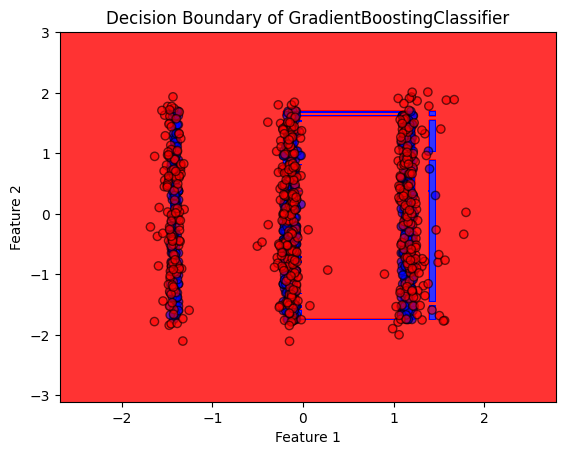

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Ensure the data is restricted to 2D
#X_combined_2d = X_combined[:, [i, j]]
#X_false = syn_model.all_X_false_train[step][:, [i, j]]
#X_combined_2d = np.vstack((X_true, X_false))

# Create a mesh to plot the decision boundary
x_min, x_max = X_combined_ij[:, 0].min() - 1, X_combined_ij[:, 0].max() + 1
y_min, y_max = X_combined_ij[:, 1].min() - 1, X_combined_ij[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Predict the function value for the whole grid
Z = clf_ij.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the contour and training examples
plt.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(('red', 'blue')))
plt.scatter(X_combined_ij[:, 0], X_combined_ij[:, 1], c=y_combined_ij, edgecolor='k', marker='o', alpha=0.6, cmap=ListedColormap(('red', 'blue')))
plt.title("Decision Boundary of GradientBoostingClassifier")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


In [ ]:
syn_model.loss_list

AttributeError: 'smote_plugin' object has no attribute 'loss_list'

In [ ]:
plt.plot(syn_model.loss_list)

AttributeError: 'smote_plugin' object has no attribute 'loss_list'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.log10(syn_model.loss_list))

AttributeError: 'smote_plugin' object has no attribute 'loss_list'

In [ ]:
i, j = 0, 1
n_steps = 4
X_true = syn_model.X_true[:, [i, j]].detach().cpu()[:len(syn_model.all_X_false_train[n_steps])]
plt.scatter(syn_model.all_X_false_train[n_steps][:, i], syn_model.all_X_false_train[n_steps][:, j], alpha=0.1)
plt.scatter(X_true[:, i], X_true[:, j], alpha=0.1)

AttributeError: 'smote_plugin' object has no attribute 'X_true'

In [8]:
X.shape

(20640, 4)

In [18]:
X.shape

(20640, 4)

true (512, 4)
false (512, 4)
Accuracy of GradientBoostingClassifier: 0.5463
NORMALIZING
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Accuracy of TabPFNClassifier: 0.4683
Accuracy of TabPFNClassifier: 0.4390


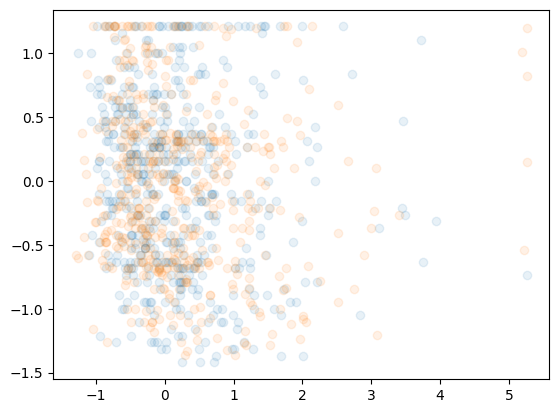

In [2]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from tabpfn import TabPFNClassifier as TabPFNClassifier_old
from tabpfn_client import TabPFNClassifier

X_false = syn_model.generate(512).numpy()
#X_true = X[-len(X_false):, :2]
X_true = X[-len(X_false):, :]

print("true", X_true.shape)
print("false", X_false.shape)
# plot
plt.scatter(X_true[:, 0], X_true[:, 1], alpha=0.1)
plt.scatter(X_false[:, 0], X_false[:, 1], alpha=0.1)

X_combined = np.vstack((X_true, X_false))
y_combined = np.hstack((np.ones(X_true.shape[0]), np.zeros(X_false.shape[0])))

X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of GradientBoostingClassifier: {accuracy:.4f}")

clf_tabpfn = TabPFNClassifier_old()
clf_tabpfn.fit(X_train, y_train, overwrite_warning=True)
y_pred_tabpfn = clf_tabpfn.predict(X_test)
accuracy_tabpfn = accuracy_score(y_test, y_pred_tabpfn)
print(f"Accuracy of TabPFNClassifier: {accuracy_tabpfn:.4f}")

clf_tabpfn_client = TabPFNClassifier()
clf_tabpfn_client.fit(X_train, y_train)
y_pred_tabpfn_client = clf_tabpfn_client.predict(X_test)
accuracy_tabpfn_client = accuracy_score(y_test, y_pred_tabpfn_client)
print(f"Accuracy of TabPFNClassifier: {accuracy_tabpfn_client:.4f}")




Step 0
NORMALIZING
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step 1
NORMALIZING
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step 2
NORMALIZING
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step 3
NORMALIZING
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step 4
NORMALIZING
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step 5
NORMALIZING
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step 6
NORMALIZING
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step 7
NORMALIZING
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step 8
NORMALIZING
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step 9
NORMALIZING
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step 10
NORMALIZING
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step 11
NORMALIZING
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step 12
NORMALIZING
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step 13
NORMALIZING
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step 14
NORMALIZING
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step 15
NORMALIZING
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


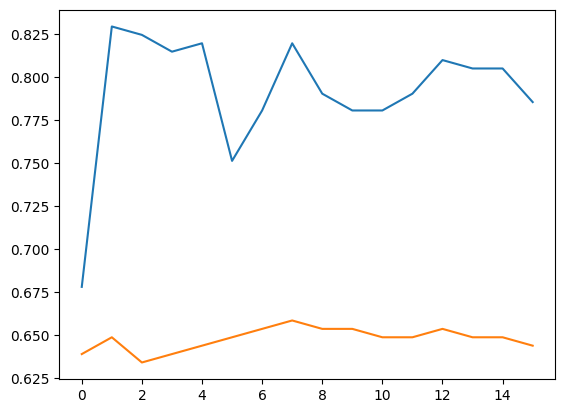

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from tabpfn import TabPFNClassifier

accuracy_list = []
accuracy_list_tabpfn = []
accuracy_list_dummy = []
for step in range(0, len(syn_model.all_X_false_train), 1):
    print(f"Step {step}")

    # Prepare the data
    #X_true = syn_model.X_true[:1000][:, [i, j]]
    X_false = syn_model.all_X_false_train[step][:, [i, j]]
    X_combined = np.vstack((X_true, X_false))
    y_combined = np.hstack((np.ones(X_true.shape[0]), np.zeros(X_false.shape[0])))

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

    # Train the GradientBoostingClassifier
    clf = GradientBoostingClassifier()
    # Initialize the DummyClassifier
    dummy_clf = DummyClassifier(strategy="most_frequent")
    tabpfn_clf = TabPFNClassifier()
    clf.fit(X_train, y_train)
    dummy_clf.fit(X_train, y_train)
    tabpfn_clf.fit(X_train, y_train, overwrite_warning=True)
    # Predict and evaluate
    y_pred = clf.predict(X_test)
    y_dummy_pred = dummy_clf.predict(X_test)
    y_tabpfn_pred = tabpfn_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    dummy_accuracy = accuracy_score(y_test, y_dummy_pred)
    tabpfn_accuracy = accuracy_score(y_test, y_tabpfn_pred)
    #print(f"Accuracy of GradientBoostingClassifier at step {step}: {accuracy:.4f}")
    #print(f"Accuracy of DummyClassifier at step {step}: {dummy_accuracy:.4f}")
    accuracy_list.append(accuracy)
    accuracy_list_dummy.append(dummy_accuracy)
    accuracy_list_tabpfn.append(tabpfn_accuracy)

plt.plot(accuracy_list)
plt.plot(accuracy_list_tabpfn)
#plt.plot(accuracy_list_dummy)




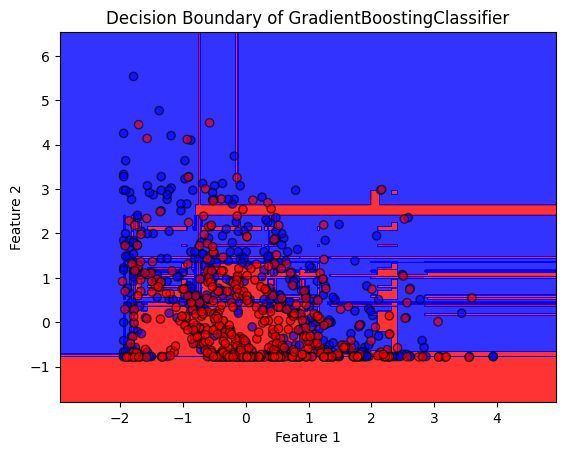

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Ensure the data is restricted to 2D
#X_combined_2d = X_combined[:, [i, j]]
step = 2
X_false = syn_model.all_X_false_train[step][:, [i, j]]
X_combined_2d = np.vstack((X_true, X_false))

# Create a mesh to plot the decision boundary
x_min, x_max = X_combined_2d[:, 0].min() - 1, X_combined_2d[:, 0].max() + 1
y_min, y_max = X_combined_2d[:, 1].min() - 1, X_combined_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Predict the function value for the whole grid
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the contour and training examples
plt.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(('red', 'blue')))
plt.scatter(X_combined_2d[:, 0], X_combined_2d[:, 1], c=y_combined, edgecolor='k', marker='o', alpha=0.6, cmap=ListedColormap(('red', 'blue')))
plt.title("Decision Boundary of GradientBoostingClassifier")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


NORMALIZING
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


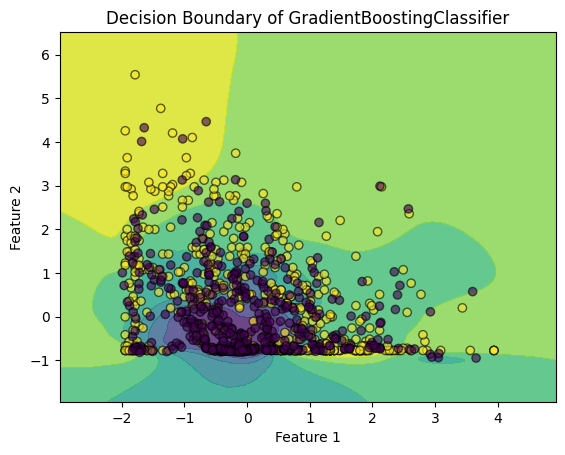

In [17]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Ensure the data is restricted to 2D
#X_combined_2d = X_combined[:, [i, j]]
step = 30
X_false = syn_model.all_X_false_train[step][:, [i, j]]
X_combined = np.vstack((X_true, X_false))
y_combined = np.hstack((np.ones(X_true.shape[0]), np.zeros(X_false.shape[0])))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# Train the GradientBoostingClassifier
tabpfn_clf = TabPFNClassifier(device="cuda:0")
tabpfn_clf.fit(X_train, y_train, overwrite_warning=True)

X_combined_2d = X_combined

# Create a mesh to plot the decision boundary
x_min, x_max = X_combined_2d[:, 0].min() - 1, X_combined_2d[:, 0].max() + 1
y_min, y_max = X_combined_2d[:, 1].min() - 1, X_combined_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.03),
                     np.arange(y_min, y_max, 0.03))

# Predict the function value for the whole grid
Z = tabpfn_clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

# Plot the contour and training examples
plt.contourf(xx, yy, Z, alpha=0.8, cmap="viridis")#cmap=ListedColormap(('red', 'blue')))
plt.scatter(X_combined_2d[:, 0], X_combined_2d[:, 1], c=y_combined, edgecolor='k', marker='o', alpha=0.6, cmap="viridis")#ListedColormap(('red', 'blue')))
plt.title("Decision Boundary of GradientBoostingClassifier")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


In [ ]:
(syn_model.all_X_false_train[0] - syn_model.all_X_false_train[2]).max()

0.019990027

In [ ]:
syn_model.accuracy_list

[0.49000000953674316, 0.5565000176429749]

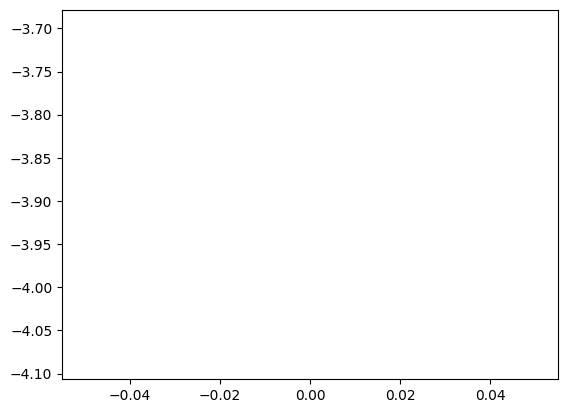

In [4]:
import numpy as np
plt.plot(np.log10(syn_model.loss_list))

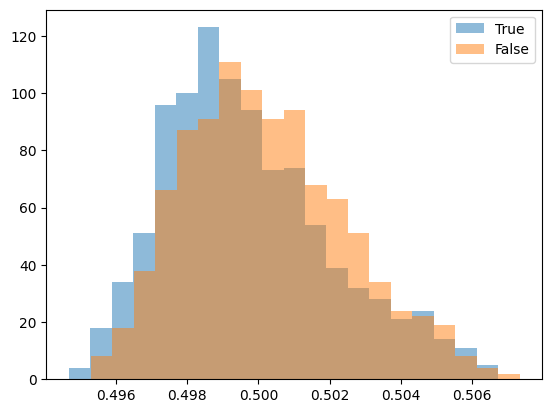

In [121]:
plt.hist(tabpfn_output_proba[y_test==1][:, 0], bins=20, alpha=0.5, label="True")
plt.hist(tabpfn_output_proba[y_test==0][:, 0], bins=20, alpha=0.5, label="False")
plt.legend()

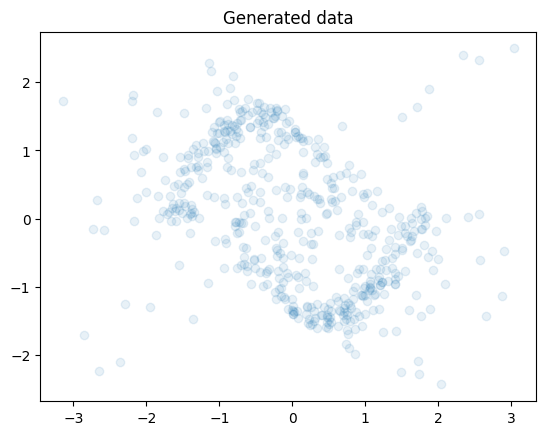

In [122]:
#plt.scatter(X[:, 0], X[:, 1], alpha=0.1)
plt.scatter(X_false_train[:, 0], X_false_train[:, 1], alpha=0.1)
plt.title("Generated data")
plt.show()

In [ ]:
X.shape

(1000, 2)